# Arctic Permafrost Modeling

ATS was initially developed out of a desire to model Arctic permafrost using the best available understanding of cryosphere processes, including subsurface flow in partially saturated, partially frozen soils.  These simulations form the basis for doing this work, and represent an approach designed for continuous permafrost.

This demo also is useful for seeing how layering works in ATS, as there are heterogeneous properties throughout (peat and mineral soil layers).

The spinup of this sequence is as follows:

* freezeup: Freeze the steady-state water table from below, establishing a saturated ice table.

Applications in real domains should also likely run several years of cyclic steady-state spinup, driving a column with idealized meteorological data to generate a climatologically "typical" year.  This establishes a permafrost vs active layer, reasonable saturation state, etc.

After these, many choices are available.  

* column_permafrost: This demonstrates a standard 1D column run with full transient physics.
* column_transect: This adds 2D topography and snow distribution, ensuring that snow fills low lying areas first.


In [1]:
%matplotlib inline
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import h5py
import ats_xdmf
import plot_column_data
import colors
from itertools import islice
import numpy as npat
import numpy as np
import matplotlib.cm
from matplotlib import pyplot as plt

## spinup: Freeze steady-state to generate ice column

Transient simulations in areas of continuous permafrost are initialized in the winter to make spinup simpler.  Therefore we start from a fully frozen domain (instead of the partially frozen domain that would be required for starting any other time of year).  

Transient simulations in areas of seasonally frozen ground, however, would typically be started in the summer for the same reason.  Transient simulations in areas of discontinuous permafrost or areas with taliks are challenging, and typically need more extensive spinup processes.

For continuous permafrost, to establish this fully-frozen domain, we freeze the hydrostatic water column from below until the solution reaches steady-state again.  This "pseudo-transient" approach is easier for solvers than solving the steady-state problem.  This is done in the subsurface only, solving coupled Richards and energy equations.

Here we look at a study from the Barrow Environmental Observatory in Utqiagvik, AK.  The bottom boundary temperature is set at -9 F, which is, according to deep borehole data, a reasonable temperature for deep permafrost in Barrow.  As the column freezes, water expands to form ice, pushing the water above it up.  This results in a careful balance -- we want to set the bottom pressure in `freezeup` such that, when frozen, the ice table is near the surface, but not above it (which would break the problem here because a no flux condition is put on that top surface).  The calculation of such a pressure is difficult, as it depends upon soil properties, freezing rates, and other dynamic things, so a test-and-check approach is taken.

First, an initial water table location is specified by the hydrostatic initial condition.  After the simulation, if the resulting ice table is too high, the pressure in the top cell will blow up, and the process is repeated with a lower initial water table.   If the resulting ice table is too low, the entire active layer will happen in an unsaturated zone, and the soil will never saturate, so the initial water table must be adjusted upwards.  Typically, for coastal polygonal permafrost, the soil is quite wet, so we work to get the ice table as close to the surface as possible.  More thought might be required for a drier condition, but remember that too wet is rarely an issue (things can drain over a few dynamic years fairly quickly as long as they thaw, but filling up from too dry takes a much longer time).  Bisection on the initial water table can be used to quickly find a value that hits an appropriate ice table level.

NOTE: From here on, transient problems are plotted such that early times have low intensity colors, and late times are high intensity colors.  The initial condition is therefore the lightest line, while the darkest line is the final, steady-state solution.

NOTE: This run takes some time (especially if the code is built in debug mode), up to ~10 minutes.

[     0.           3192.90932366   6497.16279588  10440.30515699
  14014.08987922  17517.99612922  20562.70099033  24086.57251811
  28079.62807366  32072.68362922  35676.41626811  39629.54126811
  43482.83987922  46926.85029588  49717.69976962  52508.39326463
  54902.50291111  58546.16610556  62539.22166111  66532.27721667
  70525.33277222  74518.38832778  78511.44388333  82504.49943889
  86497.55499445  90490.61055     94483.66610556  98476.72166111
 102469.77721667 106462.83277222 110455.88832778 114448.94388333
 118441.99943889 122435.05499445 126428.11055    130421.16610556
 134414.22166111 138407.27721667 142400.33277222 146393.38832778
 150386.44388333 154379.49943889 158372.55499445 162365.61055
 166358.66610556 170351.72166111 174344.77721667 178337.83277222
 182330.88832778 186323.94388333 190316.99943889 194310.05499445
 198303.11055    202296.16610556 206289.22166111 210282.27721667
 214275.33277222 218268.38832778 222261.44388333 226254.49943889
 230247.55499445 234240.6105

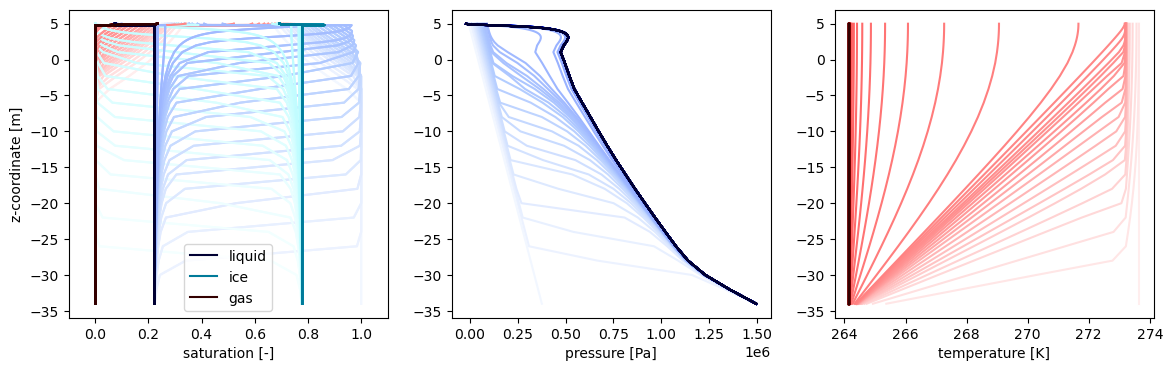

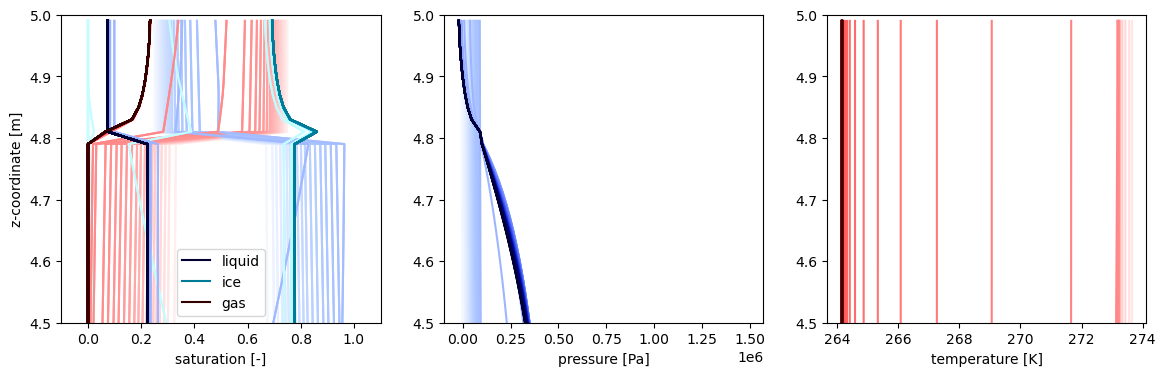

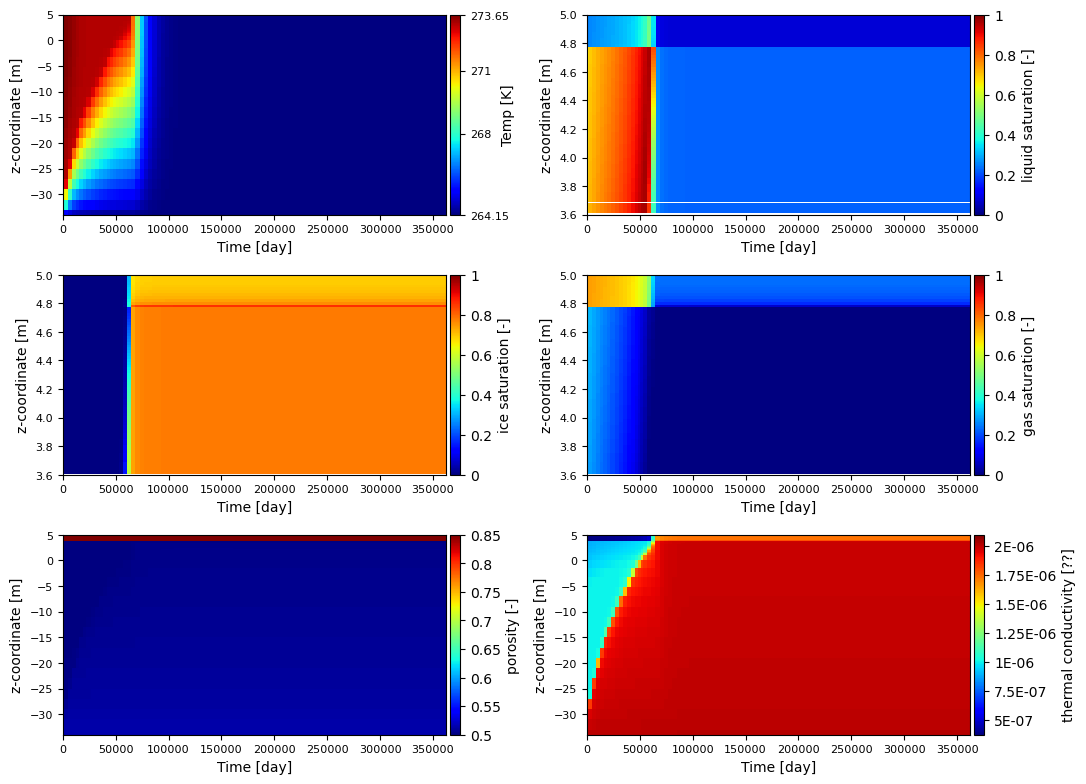

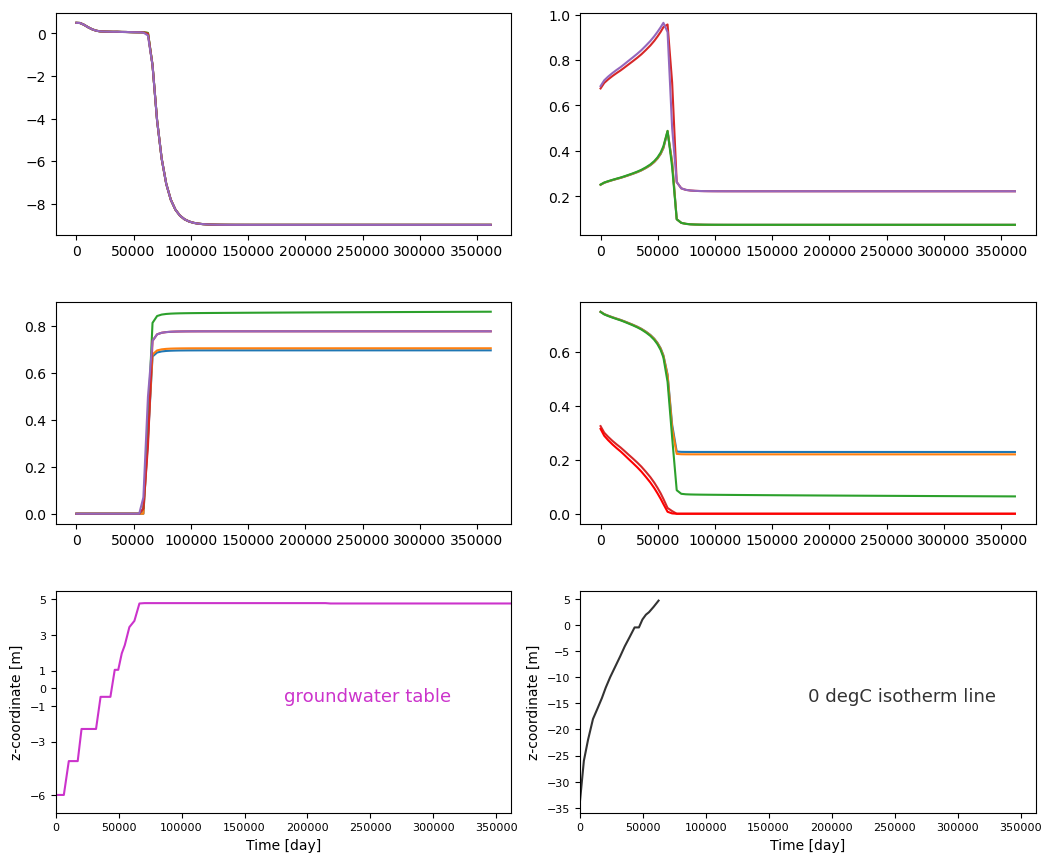

In [2]:
# plot the solution
directory = "results-freezeup"

#
# plot the solution
#
def plot2(dirname, axs):
    """A generic plotting function that plots saturation as a function of depth."""
    vis = ats_xdmf.VisFile(dirname, time_unit='d')
    vis.loadMesh(columnar=True)
    
    plot_column_data.plot_subsurface(vis, ['pressure',], axs[0], None,cmap='jet')
    axs[0].set_xlabel('pressure [Pa]')
    axs[0].set_ylabel('z [m]')
    
    plot_column_data.plot_subsurface(vis, ['saturation_liquid',], axs[1], None, cmap='jet')
    axs[1].set_xlabel('saturation [-]')
    axs[1].set_ylabel('z [m]')

def plot(directory, axs, style):
    # load the data
    vis = ats_xdmf.VisFile(directory, time_unit='d')
    vis.loadMesh(columnar=True)
    dati = np.array([vis.getArray(v) for v in ["pressure", "pressure", "saturation_liquid", 
                                    "saturation_ice", "saturation_gas", "temperature"]])
    times = vis.times
    print(times)
    print (vis)
    
    ice = colors.cm_mapper(-10000, times[-1], colors.ice_cmap())
    water = colors.cm_mapper(-10000, times[-1], colors.water_cmap())
    gas = colors.cm_mapper(-10000, times[-1], colors.gas_cmap())    
    
    # plot saturation of liquid, pressure
    z = vis.centroids[:,2]
#    td = np.empty( (len(z),len(times)) ) # an empty array to save all times of obs
    for i,t in enumerate(times):
        label = False
        if i == len(times)-1:
            axs[0].plot(dati[2,i,:],z, style, color=water(t), label='liquid')
            axs[0].plot(dati[3,i,:],z, style, color=ice(t), label='ice')
            axs[0].plot(dati[4,i,:],z, style, color=gas(t), label='gas')
        else:
            axs[0].plot(dati[2,i,:],z, style, color=water(t))
            axs[0].plot(dati[3,i,:],z, style, color=ice(t))
            axs[0].plot(dati[4,i,:],z, style, color=gas(t))
        axs[2].plot(dati[5,i,:],z, style, color=gas(t))
        axs[1].plot(dati[1,i,:],z, style, color=water(t))
        axs[0].plot(dati[2,i,:],z, style, color=water(t))
        axs[0].plot(dati[3,i,:],z, style, color=ice(t))
        axs[0].plot(dati[4,i,:],z, style, color=gas(t))

def plot2d(directory, axs):
    # load the data
    vis = ats_xdmf.VisFile(directory, time_unit='d')
    vis.loadMesh(columnar=True)
    dati = np.array([vis.getArray(v) for v in ["pressure", "pressure", "saturation_liquid", 
                                    "saturation_ice", "saturation_gas", "temperature","porosity","thermal_conductivity"]])
    times = vis.times 
    z = vis.centroids[:,2] #  
    print(z)
### creating the size of the marker depending on the space of grid cells (discretization)
    zi = np.concatenate([z[1:],[2*z[-1]-z[-2]] ]) #print(zi )
    width_cell = (zi-z)*30 # print(width_cell)
### creating the size of the marker depending on the space of grid cells (discretization)    
## 2D plotting for regular grids
#    td = np.empty( (len(z),len(times)) ) # an empty array to save all times of obs
#    for i,t in enumerate(times):
#        td[:,i] = dati[5,i,:]  # saving temperature
#    cs = plt.pcolor (td, cmap='jet')  # vmin =xxx, vmax=xxx  
#    cb = plt.colorbar(cs, orientation='vertical',pad=0.01,shrink=1.0, format='%G')
#    cb.set_ticks([273.15-9, 268, 271, 273.15+0.5])
#    cb.set_ticklabels([273.15-9, 268, 271, 273.15+0.5],fontsize=8)
#    cb.set_label('Temperature [K]', fontsize=10)

## 2D plotting for non-regular grids
    td = np.empty( (len(z)*len(times),2+4+1+2) )
    for i,t in enumerate(times):
        td[i*len(z):(i+1)*len(z),0] = [t]*len(z)    # saving times
        td[i*len(z):(i+1)*len(z),1] = z       # saving z-coordinates
        td[i*len(z):(i+1)*len(z),2] = dati[5,i,:]   # saving temperature 
        td[i*len(z):(i+1)*len(z),3] = dati[2,i,:]   # liquid saturation 
        td[i*len(z):(i+1)*len(z),4] = dati[3,i,:]   # ice saturation 
        td[i*len(z):(i+1)*len(z),5] = dati[4,i,:]   # gas saturation 
        td[i*len(z):(i+1)*len(z),6] = width_cell*70 # marker size
        td[i*len(z):(i+1)*len(z),7] = dati[6,i,:]   # saving porosity
        td[i*len(z):(i+1)*len(z),8] = dati[7,i,:]   # saving thermal conductivity

# ploting temperature
#      cs = plt.pcolor (td[:,0],td[:,1],td[:,2], cmap='jet', shading='auto',vmin =min(td[:,2]),vmax=max(td[:,2]))
    im =axs[0,0].scatter(x=td[:,0],y=td[:,1],c=td[:,2],cmap='jet',s=60,marker='$\u25AE$',edgecolors='none')    
    cb =plt.colorbar(im, ax=axs[0,0], orientation='vertical',pad=0.01,shrink=1.0, format='%G')
    cb.set_ticks([273.15-9, 268, 271, 273.15+0.5])
    cb.set_ticklabels([273.15-9, 268, 271, 273.15+0.5],fontsize=8)
    cb.set_label('Temp [K]', fontsize=10,labelpad=-5.5)
    axs[0,0].set_xlim(0,times[-1])
    axs[0,0].set_ylim(min(z),max(z)+0.01)
    axs[0,0].tick_params(axis='both',labelsize=8)
    axs[0,0].set_xlabel('Time [day]', fontsize=10)
    axs[0,0].set_ylabel('z-coordinate [m]', fontsize=10)
# ploting liquid saturation
    im_l =axs[0,1].scatter(x=td[:,0],y=td[:,1],c=td[:,3],cmap='jet',s=50,marker='$\u25AE$',edgecolors='none',vmin=0,vmax=1.0)#   
    cb_l =plt.colorbar(im_l, ax=axs[0,1], orientation='vertical',pad=0.01,shrink=1.0, format='%G')
    cb_l.set_label('liquid saturation [-]', fontsize=10)
    axs[0,1].set_xlim(0,times[-1])
    axs[0,1].set_ylim(3.6,max(z)+0.01)
    axs[0,1].tick_params(axis='both',labelsize=8)
    axs[0,1].set_xlabel('Time [day]', fontsize=10)
    axs[0,1].set_ylabel('z-coordinate [m]', fontsize=10)
# ploting ice saturation
    im_i =axs[1,0].scatter(x=td[:,0],y=td[:,1],c=td[:,4],cmap='jet',s=65,marker='$\u25AE$',edgecolors='none',vmin=0,vmax=1.0)#   
    cb_i =plt.colorbar(im_i, ax=axs[1,0], orientation='vertical',pad=0.01,shrink=1.0, format='%G')
    cb_i.set_label('ice saturation [-]', fontsize=10)
    axs[1,0].set_xlim(0,times[-1])
    axs[1,0].set_ylim(3.6,max(z)+0.01)
    axs[1,0].tick_params(axis='both',labelsize=8)
    axs[1,0].set_xlabel('Time [day]', fontsize=10)
    axs[1,0].set_ylabel('z-coordinate [m]', fontsize=10)
# ploting gas saturation
    im_g =axs[1,1].scatter(x=td[:,0],y=td[:,1],c=td[:,5],cmap='jet',s=65,marker='$\u25AE$',edgecolors='none',vmin=0,vmax=1.0)#   
    cb_g =plt.colorbar(im_g, ax=axs[1,1], orientation='vertical',pad=0.01,shrink=1.0, format='%G')
    cb_g.set_label('gas saturation [-]', fontsize=10)
    axs[1,1].set_xlim(0,times[-1])
    axs[1,1].set_ylim(3.6,max(z)+0.01)
    axs[1,1].tick_params(axis='both',labelsize=8)
    axs[1,1].set_xlabel('Time [day]', fontsize=10)
    axs[1,1].set_ylabel('z-coordinate [m]', fontsize=10)
# ploting porosity
    im_g =axs[2,0].scatter(x=td[:,0],y=td[:,1],c=td[:,7],cmap='jet',s=55,marker='$\u25AE$',edgecolors='none')#    ,vmin=0,vmax=1.0
    cb_g =plt.colorbar(im_g, ax=axs[2,0], orientation='vertical',pad=0.01,shrink=1.0, format='%G')
    cb_g.set_label('porosity [-]', fontsize=10)
    axs[2,0].set_xlim(0,times[-1])
    axs[2,0].set_ylim(min(z)*1+4.6*0,max(z)+0.01)
    axs[2,0].tick_params(axis='both',labelsize=8)
    axs[2,0].set_xlabel('Time [day]', fontsize=10)
    axs[2,0].set_ylabel('z-coordinate [m]', fontsize=10)
# ploting thermal conductivity
    im_g =axs[2,1].scatter(x=td[:,0],y=td[:,1],c=td[:,8],cmap='jet',s=55,marker='$\u25AE$',edgecolors='none')#    ,vmin=0,vmax=1.0
    cb_g =plt.colorbar(im_g, ax=axs[2,1], orientation='vertical',pad=0.01,shrink=1.0, format='%G')
    cb_g.set_label('thermal conductivity [??]', fontsize=10)
    axs[2,1].set_xlim(0,times[-1])
    axs[2,1].set_ylim(min(z),max(z)+0.01)
    axs[2,1].tick_params(axis='both',labelsize=8)
    axs[2,1].set_xlabel('Time [day]', fontsize=10)
    axs[2,1].set_ylabel('z-coordinate [m]', fontsize=10)
    
    
def plot_btc(directory, axs):
    # load the data
    vis = ats_xdmf.VisFile(directory, time_unit='d')
    vis.loadMesh(columnar=True)
    dati = np.array([vis.getArray(v) for v in ["pressure", "pressure", "saturation_liquid", 
                                    "saturation_ice", "saturation_gas", "temperature"]])
    times = vis.times 
    z = vis.centroids[:,2] #  print(z)
# ploting btc at the specified elevation (locations)
    print(z[-3],z[-5],z[-10],z[-25],z[-50])  # 4.95 4.91 4.81 4.51 4.01
    btc = np.empty( (1*len(times),1+5*5+1+1) ) # t, z/dati, gwt, thaw_line
    td2 = np.empty( (len(z),len(times)+1) ) # an empty array to save all times of obs
    td3 = np.empty( (len(z),len(times)+1) ) # an empty array to save all times of obs
    for i,t in enumerate(times):     
        btc[i:i+1,0] = [t]     # saving times
        btc[i:i+1,1] = z[-3]  # saving z-coordinate =4.95m
        btc[i:i+1,2] = dati[5,i,-3]-273.15 # saving temperature 
        btc[i:i+1,3] = dati[2,i,-3] # liquid saturation
        btc[i:i+1,4] = dati[3,i,-3] # ice saturation 
        btc[i:i+1,5] = dati[4,i,-3] # gas saturation  
        btc[i:i+1,6] = z[-5]  # saving z-coordinate =4.91m
        btc[i:i+1,7] = dati[5,i,-5]-273.15 # saving temperature        
        btc[i:i+1,8] = dati[2,i,-5] # liquid saturation
        btc[i:i+1,9] = dati[3,i,-5] # ice saturation 
        btc[i:i+1,10] = dati[4,i,-5] # gas saturation 
        btc[i:i+1,11] = z[-10]  # saving z-coordinates =4.81m
        btc[i:i+1,12] = dati[5,i,-10]-273.15 # saving temperature        
        btc[i:i+1,13] = dati[2,i,-10] # liquid saturation
        btc[i:i+1,14] = dati[3,i,-10] # ice saturation 
        btc[i:i+1,15] = dati[4,i,-10] # gas saturation 
        btc[i:i+1,16] = z[-25]  # saving z-coordinates =4.51m
        btc[i:i+1,17] = dati[5,i,-25]-273.15 # saving temperature        
        btc[i:i+1,18] = dati[2,i,-25] # liquid saturation
        btc[i:i+1,19] = dati[3,i,-25] # ice saturation 
        btc[i:i+1,20] = dati[4,i,-25] # gas saturation 
        btc[i:i+1,21] = z[-50]  # saving z-coordinates =4.01m
        btc[i:i+1,22] = dati[5,i,-50]-273.15 # saving temperature        
        btc[i:i+1,23] = dati[2,i,-50] # liquid saturation
        btc[i:i+1,24] = dati[3,i,-50] # ice saturation 
        btc[i:i+1,25] = dati[4,i,-50] # gas saturation
        #btc[i:i+1,25] = dati[4,i,-71] # print(z[-71]), index=-71 is GWT=-6 m
# collecting groundwater table data         
        td2[:,0]   = z  # saving z-coordinates, elevation
        td2[:,i+1] = dati[4,i,:]       # saving gas saturation
        aa= np.where (dati[4,i,:]==0) # find the row index having zero gas
        bb=np.where (dati[4,i,:]==0)[-1][-1] # [-1][-1] indicating the last index value of "==0"
        btc[i:i+1,26] =z[bb]
# collecting groundwater table data  
        td3[:,0]   = z  # saving z-coordinates, elevation
        td3[:,i+1] = dati[5,i,:]       # saving temp in 2d array
        cc= np.where (dati[5,i,:]>=273.15) # find the row index having positive temperatures
   #     print(cc)
        if cc[0].size==0:
            btc[i:i+1,27]=np.nan
        else:
            dd=np.where (dati[5,i,:]>=273.15)[0][0]  # [-1][-1] indicating the last index value of 
            btc[i:i+1,27] =z[dd] 
# saving the values of simulated gas saturation to get the locations of gw table
    np.savetxt("freezeup_gas_saturation.csv",
            #np.flipud()
           np.column_stack([np.arange(0,len(td2)),td2]),
#           header="times,ponded_depth,snow_depth,surf_T,snow_T",
           delimiter=',',
           comments=""
          )
# saving the values of simulated temperature to get the locations of thaw frontline
    np.savetxt("freezeup_temperature_2Darray.csv",
            #np.flipud()
           np.column_stack([np.arange(0,len(td3)),td3]),
#           header="times,ponded_depth,snow_depth,surf_T,snow_T",
           delimiter=',',
           comments=""
          )
# ploting temperature btc     
    axs[0,0].plot(btc[:,0],btc[:,2])   
    axs[0,0].plot(btc[:,0],btc[:,7])
    axs[0,0].plot(btc[:,0],btc[:,12])
    axs[0,0].plot(btc[:,0],btc[:,17])
    axs[0,0].plot(btc[:,0],btc[:,22])
# ploting liquid saturation btc   
    axs[0,1].plot(btc[:,0],btc[:,3])   
    axs[0,1].plot(btc[:,0],btc[:,8])
    axs[0,1].plot(btc[:,0],btc[:,13])
    axs[0,1].plot(btc[:,0],btc[:,18])
    axs[0,1].plot(btc[:,0],btc[:,23]) 
# ploting ice saturation btc   
    axs[1,0].plot(btc[:,0],btc[:,4])   
    axs[1,0].plot(btc[:,0],btc[:,9])
    axs[1,0].plot(btc[:,0],btc[:,14])
    axs[1,0].plot(btc[:,0],btc[:,19])
    axs[1,0].plot(btc[:,0],btc[:,24]) 
# ploting gas saturation     
    axs[1,1].plot(btc[:,0],btc[:,5])   
    axs[1,1].plot(btc[:,0],btc[:,10])
    axs[1,1].plot(btc[:,0],btc[:,15])
    axs[1,1].plot(btc[:,0],btc[:,20])
    axs[1,1].plot(btc[:,0],btc[:,25],'r-')  
# ploting groundwater table       
    axs[2,0].plot(btc[:,0],btc[:,26],'m-',alpha=0.8) 
    axs[2,0].set_xlim(0,times[-1])
    axs[2,0].set_ylim(-7,5.5)
    axs[2,0].set_yticks([5,3,1,0,-1,-3,-6])
    #axs[2,0].set_ticklabels([5.0],fontsize=8)
    #    cb.set_ticklabels([273.15-9, 268, 271, 273.15+0.5],fontsize=8)
    axs[2,0].tick_params(axis='both',labelsize=8)
    axs[2,0].set_xlabel('Time [day]', fontsize=10)
    axs[2,0].set_ylabel('z-coordinate [m]', fontsize=10)
    plt.text(0.5,0.5,'groundwater table', fontsize=13,color='m',alpha=0.8,transform=axs[2,0].transAxes)
# ploting 0 degC thaw frontline       
    axs[2,1].plot(btc[:,0],btc[:,27],'k-',alpha=0.8) 
    axs[2,1].set_xlim(0,times[-1])
    #axs[2,1].set_ylim(-7,5.5)
    #axs[2,1].set_yticks([5,3,1,0,-1,-3,-6])
    #axs[2,0].set_ticklabels([5.0],fontsize=8)
    axs[2,1].tick_params(axis='both',labelsize=8)
    axs[2,1].set_xlabel('Time [day]', fontsize=10)
    axs[2,1].set_ylabel('z-coordinate [m]', fontsize=10)
    plt.text(0.5,0.5,'0 degC isotherm line', fontsize=13,color='k',alpha=0.8,transform=axs[2,1].transAxes)
    
def decorate(axs):
    axs[0].set_xlabel('saturation [-]')
    axs[0].set_ylabel('z-coordinate [m]')
    axs[1].set_xlabel('pressure [Pa]')
    axs[2].set_xlabel('temperature [K]')
    axs[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axs[0].set_xlim([-.1,1.1])
    axs[0].legend()

#### full column
fig1, axs = plt.subplots(1,3, figsize=(14,4))
plot(directory, axs, '-')
decorate(axs)

#### and a zoomed version
fig2, axs = plt.subplots(1,3, figsize=(14,4))
plot(directory, axs, '-')
decorate(axs)
axs[0].set_ylim([4.5,5])
axs[1].set_ylim([4.5,5])
axs[2].set_ylim([4.5,5])

###### testing the plot2d
#fig, axs = plt.subplots(1,3, figsize=(14,4))
#plot2(directory, axs)

###### testing the plot2d
fig3, axs = plt.subplots(3,2, figsize=(14,9))
plt.subplots_adjust(left=0.15,bottom=0.1,right=0.85,top=0.9,wspace=0.15,hspace=0.3)
plot2d(directory, axs)
#fig3.savefig("testing.pdf")
#fig3.savefig("testing.png",dpi=300,bbox_inches='tight')

###### testing the btc at the specified location
fig4, axs = plt.subplots(3,2, figsize=(14,10))
plt.subplots_adjust(left=0.15,bottom=0.1,right=0.85,top=0.9,wspace=0.15,hspace=0.3)
plot_btc(directory, axs)
#fig4.savefig("testing.pdf")
#fig4.savefig("testing.png",dpi=300,bbox_inches='tight')


plt.show()
        

## Dynamic fully coupled run with annual cyclic steady state forcing

Next, the permafrost_column run demonstrates the typical transient column run.  This includes all thermal hydrology processes:

* subsurface flow (modified Richards)
* subsurface energy
* surface flow
* surface energy
* surface energy balance

This model is forced with meteorological data.  Here we will use DayMet, which provides daily historical QA'd datasets for meteorological data on a 1km US grid, and covers Alaska.  These datasets were created using DayMet for Barrow:

```python $ATS_SRC_DIR/tools/utils/daymet_to_ats.py 71.2718 -156.6202```

and then smoothed to generate spinup data via:

```python $ATS_SRC_DIR/tools/utils/smooth_met.py -n 10 daymet_raw_71p2718_-156p6202.h5```

This is called a spinup run because it sets a typical cyclic steady state, and puts the permafrost a reasonable state to then do dynamic, "real data" runs with met data from real years instead of averaged, typical years.  These dynamic runs use the same transient processes, just different forcing data.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4.95 4.91 4.81 4.51 4.01


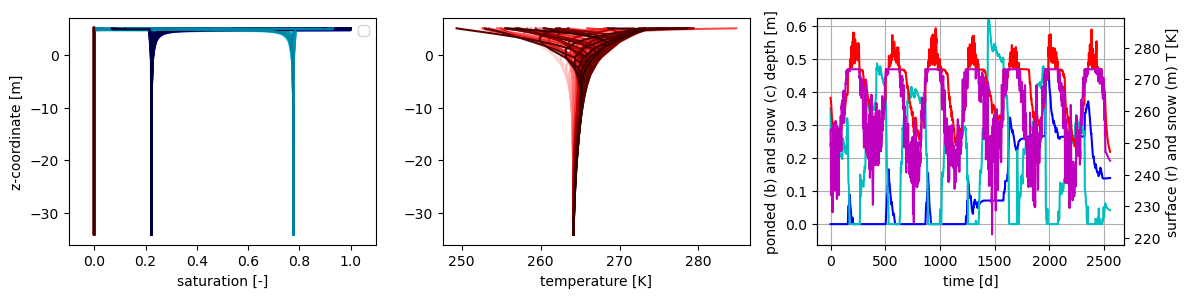

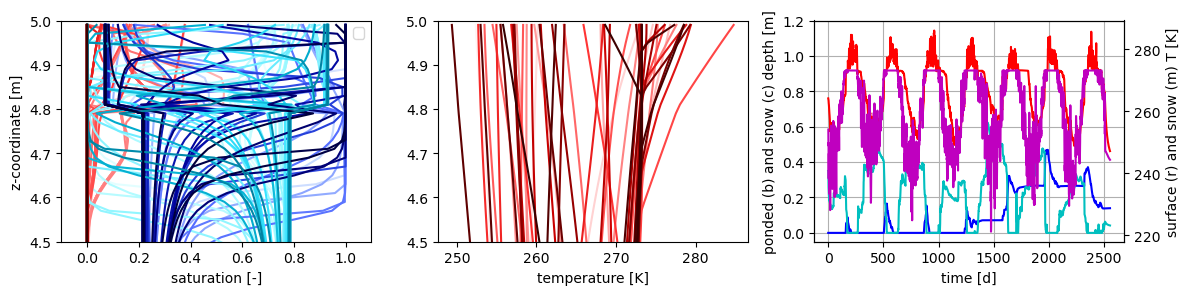

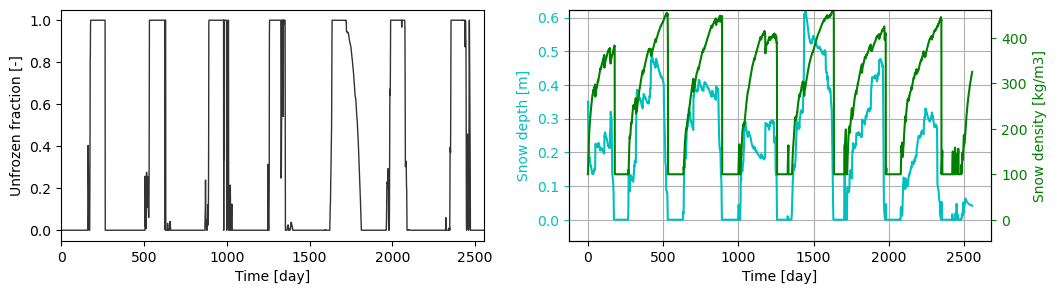

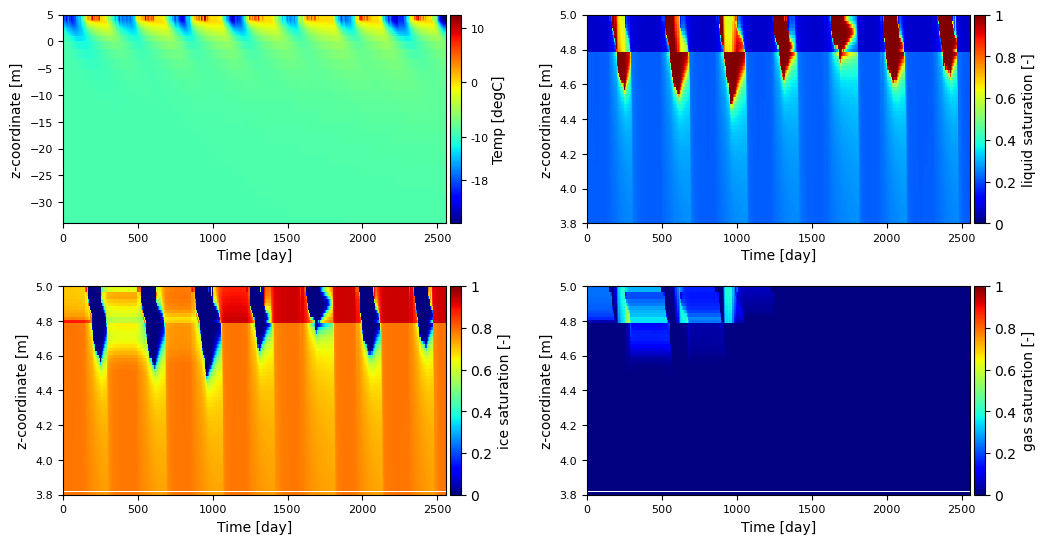

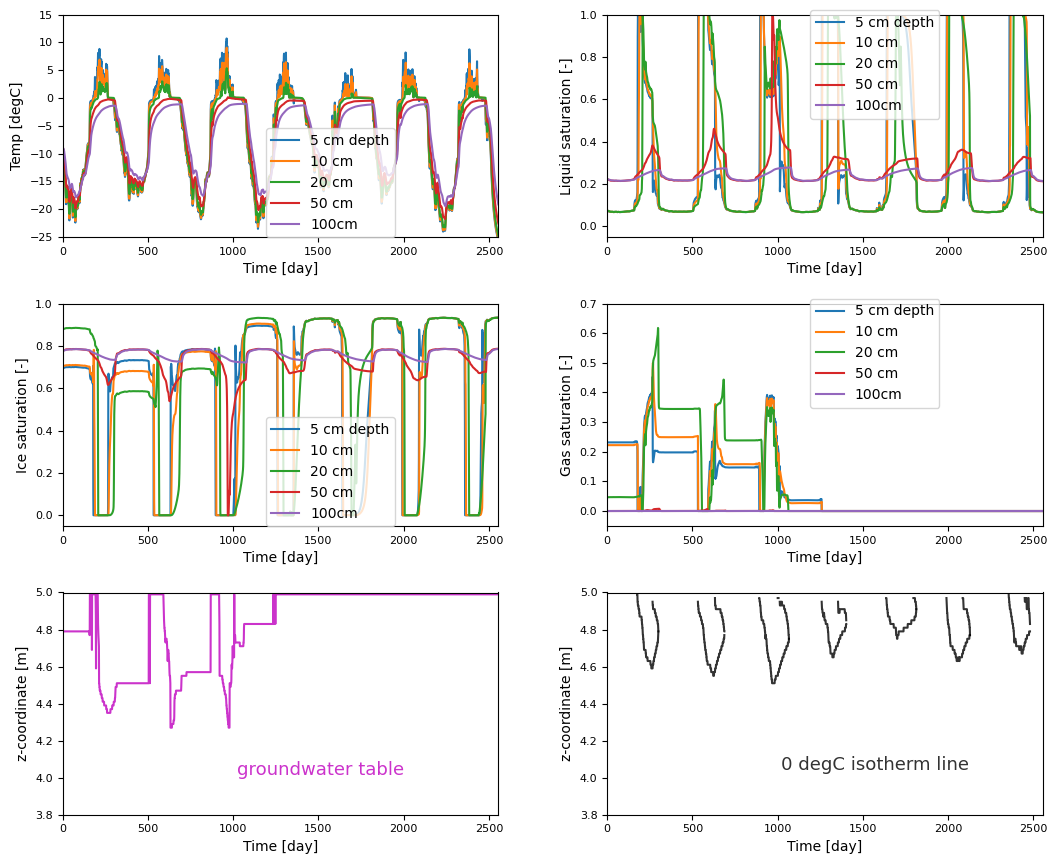

In [2]:
# plot the solution
directory = "results-barrow-beo_7yr"

def plot(directory, axs, style):
    # load the data
    vis = ats_xdmf.VisFile(directory, time_unit='d')
    vis.loadMesh(columnar=True)
    dati = np.array([vis.getArray(v) for v in ["pressure", "pressure", "saturation_liquid", 
                                    "saturation_ice", "saturation_gas", "temperature"]])
        
    viss = ats_xdmf.VisFile(directory, 'surface', time_unit='d')
    viss.loadMesh(columnar=True)
    
    vissn = viss
    vissn.loadMesh(columnar=True)    
        
    # convert times to days
    times = vis.times
    
    ice = colors.cm_mapper(-10, times[-1], colors.ice_cmap())
    water = colors.cm_mapper(-10, times[-1], colors.water_cmap())
    gas = colors.cm_mapper(-10, times[-1], colors.gas_cmap())    
    
    # plot saturation of liquid, pressure
    z = vis.centroids[:,2]
    for (i,t) in islice(enumerate(times),0,None,40):
        
        axs[1].plot(dati[5,i,:],z, style, color=gas(t))
        if i == len(times)-1:
            axs[0].plot(dati[2,i,:],z, style, color=water(t), label='liquid')
            axs[0].plot(dati[3,i,:],z, style, color=ice(t), label='ice')
            axs[0].plot(dati[4,i,:],z, style, color=gas(t), label='gas')
        else:
            axs[0].plot(dati[2,i,:],z, style, color=water(t))
            axs[0].plot(dati[3,i,:],z, style, color=ice(t))
            axs[0].plot(dati[4,i,:],z, style, color=gas(t))
            
    # inset -- plot surface water
    pd = viss.getArray('surface-ponded_depth')
    axs[2].plot(times, pd, 'b')
    if pd.max() > 0:
        axs[2].set_ylim([-.1*pd.max(), pd.max()])

    # plot snow
    snow = vissn.getArray('snow-depth')
    snow = snow + pd*0
#    snow = snow + pd
    axs[2].plot(times, snow, 'c')
    if snow.max() > 0:
        axs[2].set_ylim([-.1*snow.max(), snow.max()])

########################### adding the unfrozen fraction
#    unfro_fra = viss.getArray("unfrozen_fraction")
#    axs[2].plot(times, unfro_fra, 'k', lw=2.5, alpha=0.5)
########################### adding the unfrozen fraction

    # plot surface temp
    surf_T = viss.getArray("surface-temperature")
    axs[3].plot(times, surf_T, 'r')
    
    # plot snow temp
    snow_T = vissn.getArray('snow-temperature')
    snow_T[0] = np.nan # this is initially zero which screws up the plot
    axs[3].plot(times, snow_T, 'm')
    
    ############ plot snow density
    snow_d = vissn.getArray('snow-density')
    
    return times, pd, snow, snow_d, surf_T, snow_T;


def plot1d(directory, axs, style):
    # load the data
    vis = ats_xdmf.VisFile(directory, time_unit='d')
    vis.loadMesh(columnar=True)        
    viss = ats_xdmf.VisFile(directory, 'surface', time_unit='d')
    vissn = viss
    vissn.loadMesh(columnar=True)    
    # convert times to days
    times = vis.times     
############ plot the unfrozen fraction
    unfro_fra = viss.getArray("unfrozen_fraction")
    axs[0].plot(times, unfro_fra, 'k', lw=1.0, alpha=0.8)
############ plot the unfrozen fraction
############ plot snow depth
    snow = vissn.getArray('snow-depth')
    snow = snow + pd*0
#    snow = snow + pd
    axs[1].plot(times, snow, 'c')
    if snow.max() > 0:
        axs[1].set_ylim([-.1*snow.max(), snow.max()])
############ plot snow density
    snow_d = vissn.getArray('snow-density')
    axs[2].plot(times, snow_d, 'g')
    if snow_d.max() > 0:
        axs[2].set_ylim([-.1*snow_d.max(), snow_d.max()])
####        
    axs[0].set_xlim(0,times[-1])
    axs[0].set_xlabel('Time [day]', fontsize=10)
    axs[0].set_ylabel('Unfrozen fraction [-]', fontsize=10)        
    axs[1].set_xlabel('Time [day]', fontsize=10)
    axs[1].set_ylabel('Snow depth [m]')
    axs[1].yaxis.label.set_color('c')
    axs[1].tick_params(axis='y',colors='c')
    axs[2].set_ylabel('Snow density [kg/m3]')
    axs[2].yaxis.label.set_color('g')
    axs[2].tick_params(axis='y',colors='g')

    
def plot2d(directory, axs):
    # load the data
    vis = ats_xdmf.VisFile(directory, time_unit='d')
    vis.loadMesh(columnar=True)
    dati = np.array([vis.getArray(v) for v in ["pressure", "pressure", "saturation_liquid", 
                                    "saturation_ice", "saturation_gas", "temperature"]])
    times = vis.times 
    z = vis.centroids[:,2]

## 2D plotting for regular grids
#    td = np.empty( (len(z),len(times)) ) # an empty array to save all times of obs
#    for i,t in enumerate(times):
#        td[:,i] = dati[5,i,:]  # saving temperature
#    cs = plt.pcolor (td, cmap='jet')  # vmin =xxx, vmax=xxx  
#    cb = plt.colorbar(cs, orientation='vertical',pad=0.01,shrink=1.0, format='%G')
#    cb.set_ticks([273.15-9, 268, 271, 273.15+0.5])
#    cb.set_ticklabels([273.15-9, 268, 271, 273.15+0.5],fontsize=8)
#    cb.set_label('Temperature [K]', fontsize=10)

## 2D plotting for non-regular grids
    td = np.empty( (len(z)*len(times),2+4) )
    for i,t in enumerate(times):
        td[i*len(z):(i+1)*len(z),0] = [t]*len(z)    # saving times
        td[i*len(z):(i+1)*len(z),1] = z     # saving z-coordinates
        td[i*len(z):(i+1)*len(z),2] = dati[5,i,:]   # saving temperature 
        td[i*len(z):(i+1)*len(z),3] = dati[2,i,:]   # liquid saturation 
        td[i*len(z):(i+1)*len(z),4] = dati[3,i,:]   # ice saturation 
        td[i*len(z):(i+1)*len(z),5] = dati[4,i,:]   # gas saturation 
# ploting temperature
#      cs = plt.pcolor (td[:,0],td[:,1],td[:,2], cmap='jet', shading='auto',vmin =min(td[:,2]),vmax=max(td[:,2]))
    im =axs[0,0].scatter(x=td[:,0],y=td[:,1],c=td[:,2],cmap='jet',s=60,marker='$\u25AE$',edgecolors='none')    
    cb =plt.colorbar(im, ax=axs[0,0], orientation='vertical',pad=0.01,shrink=1.0, format='%G')
    cb.set_ticks([273.15-18, 273.15-10, 273.15+0, 273.15+10])
    cb.set_ticklabels([-18, -10, 0, 10],fontsize=8)
    cb.set_label('Temp [degC]', fontsize=10,labelpad=2.5)
    axs[0,0].set_xlim(0,times[-1])
    axs[0,0].set_ylim(min(z),max(z)+0.01)
    axs[0,0].tick_params(axis='both',labelsize=8)
    axs[0,0].set_xlabel('Time [day]', fontsize=10)
    axs[0,0].set_ylabel('z-coordinate [m]', fontsize=10)
# ploting liquid saturation
    im_l =axs[0,1].scatter(x=td[:,0],y=td[:,1],c=td[:,3],cmap='jet',s=40,marker='$\u25AE$',edgecolors='none',vmin=0,vmax=1.0)#   
    cb_l =plt.colorbar(im_l, ax=axs[0,1], orientation='vertical',pad=0.01,shrink=1.0, format='%G')
    cb_l.set_label('liquid saturation [-]', fontsize=10)
    axs[0,1].set_xlim(0,times[-1])
    axs[0,1].set_ylim(3.8,max(z)+0.01)
    axs[0,1].tick_params(axis='both',labelsize=8)
    axs[0,1].set_xlabel('Time [day]', fontsize=10)
    axs[0,1].set_ylabel('z-coordinate [m]', fontsize=10)
# ploting ice saturation
    im_i =axs[1,0].scatter(x=td[:,0],y=td[:,1],c=td[:,4],cmap='jet',s=40,marker='$\u25AE$',edgecolors='none',vmin=0,vmax=1.0)#   
    cb_i =plt.colorbar(im_i, ax=axs[1,0], orientation='vertical',pad=0.01,shrink=1.0, format='%G')
    cb_i.set_label('ice saturation [-]', fontsize=10)
    axs[1,0].set_xlim(0,times[-1])
    axs[1,0].set_ylim(3.8,max(z)+0.01)
    axs[1,0].tick_params(axis='both',labelsize=8)
    axs[1,0].set_xlabel('Time [day]', fontsize=10)
    axs[1,0].set_ylabel('z-coordinate [m]', fontsize=10)
# ploting gas saturation
    im_g =axs[1,1].scatter(x=td[:,0],y=td[:,1],c=td[:,5],cmap='jet',s=40,marker='$\u25AE$',edgecolors='none',vmin=0,vmax=1.0)#   
    cb_g =plt.colorbar(im_g, ax=axs[1,1], orientation='vertical',pad=0.01,shrink=1.0, format='%G')
    cb_g.set_label('gas saturation [-]', fontsize=10)
    axs[1,1].set_xlim(0,times[-1])
    axs[1,1].set_ylim(3.8,max(z)+0.01)
    axs[1,1].tick_params(axis='both',labelsize=8)
    axs[1,1].set_xlabel('Time [day]', fontsize=10)
    axs[1,1].set_ylabel('z-coordinate [m]', fontsize=10)

def plot_btc(directory, axs):
    # load the data
    vis = ats_xdmf.VisFile(directory, time_unit='d')
    vis.loadMesh(columnar=True)
    dati = np.array([vis.getArray(v) for v in ["pressure", "pressure", "saturation_liquid", 
                                    "saturation_ice", "saturation_gas", "temperature"]])
    times = vis.times 
    z = vis.centroids[:,2] #  print(z)
# ploting btc at the specified depths (locations)
    print(z[-3],z[-5],z[-10],z[-25],z[-50])  # 4.95 4.91 4.81 4.51 4.01
    btc = np.empty( (1*len(times),1+5*5+1+2) ) # t, z/dati, gwt, thaw_line
    td2 = np.empty( (len(z),len(times)+1) ) # an empty array to save all times of obs
    td3 = np.empty( (len(z),len(times)+1) ) # an empty array to save all times of obs
    for i,t in enumerate(times):     
        btc[i:i+1,0] = [t]     # saving times
        btc[i:i+1,1] = z[-3]  # saving z-coordinates
        btc[i:i+1,2] = dati[5,i,-3]-273.15 # saving temperature 
        btc[i:i+1,3] = dati[2,i,-3] # liquid saturation
        btc[i:i+1,4] = dati[3,i,-3] # ice saturation 
        btc[i:i+1,5] = dati[4,i,-3] # gas saturation  
        btc[i:i+1,6] = z[-5]  # saving z-coordinates
        btc[i:i+1,7] = dati[5,i,-5]-273.15 # saving temperature        
        btc[i:i+1,8] = dati[2,i,-5] # liquid saturation
        btc[i:i+1,9] = dati[3,i,-5] # ice saturation 
        btc[i:i+1,10] = dati[4,i,-5] # gas saturation 
        btc[i:i+1,11] = z[-10]  # saving z-coordinates
        btc[i:i+1,12] = dati[5,i,-10]-273.15 # saving temperature        
        btc[i:i+1,13] = dati[2,i,-10] # liquid saturation
        btc[i:i+1,14] = dati[3,i,-10] # ice saturation 
        btc[i:i+1,15] = dati[4,i,-10] # gas saturation 
        btc[i:i+1,16] = z[-25]  # saving z-coordinates
        btc[i:i+1,17] = dati[5,i,-25]-273.15 # saving temperature        
        btc[i:i+1,18] = dati[2,i,-25] # liquid saturation
        btc[i:i+1,19] = dati[3,i,-25] # ice saturation 
        btc[i:i+1,20] = dati[4,i,-25] # gas saturation 
        btc[i:i+1,21] = z[-50]  # saving z-coordinates
        btc[i:i+1,22] = dati[5,i,-50]-273.15 # saving temperature        
        btc[i:i+1,23] = dati[2,i,-50] # liquid saturation
        btc[i:i+1,24] = dati[3,i,-50] # ice saturation 
        btc[i:i+1,25] = dati[4,i,-50] # gas saturation 
# collecting groundwater table data       
        td2[:,0]   = z  # saving z-coordinates, elevation
        td2[:,i+1] = dati[4,i,:]       # saving gas saturation
        aa= np.where (dati[4,i,:]==0)  # find the row index having zero gas
        bb=np.where (dati[4,i,:]==0)[-1][-1] # [-1][-1] indicating the last index value of "==0"
        btc[i:i+1,26] =z[bb]
# collecting groundwater table data  
        td3[:,0]   = z  # saving z-coordinates, elevation
        td3[:,i+1] = dati[5,i,:]       # saving temp in 2d array
        cc= np.where (dati[5,i,:]>=273.15) # find the row index having positive temperatures
   ##           print(cc)  
        if cc[0].size==0:
            btc[i:i+1,27]=np.nan  #btc[i:i+1,27] is for left side of envelope of 0-degC
            btc[i:i+1,28]=np.nan  #btc[i:i+1,28] is for right side of envelope of 0-degC
        else:
            dd=np.where (dati[5,i,:]>=273.15)[0][0]   # [-1][-1] indicating the first index value
            btc[i:i+1,27] =z[dd]
            ee=np.where (dati[5,i,:]>=273.15)[-1][-1] # [-1][-1] indicating the last index value 
   ##           print(ee),print(z[ee]),print(len(z))
            if ee == len(z)-1: # "1" denotes removing the most top one; "0" denotes keeping the most top one
                btc[i:i+1,28] =np.nan
            else:
                btc[i:i+1,28] =z[ee]
    
# ploting temperature btc    
    T_5cm,=axs[0,0].plot(btc[:,0],btc[:,2])   
    T_10cm,=axs[0,0].plot(btc[:,0],btc[:,7])
    T_20cm,=axs[0,0].plot(btc[:,0],btc[:,12])
    T_50cm,=axs[0,0].plot(btc[:,0],btc[:,17])
    T_100cm,=axs[0,0].plot(btc[:,0],btc[:,22])
    Temp_10cm=btc[:,7]
    Temp_50cm=btc[:,17]
    axs[0,0].set_xlim(0,times[-1])
    axs[0,0].set_ylim(-25,15)
    axs[0,0].tick_params(axis='both',labelsize=8)
    axs[0,0].set_xlabel('Time [day]', fontsize=10)
    axs[0,0].set_ylabel('Temp [degC]', fontsize=10)
    axs[0,0].legend((T_5cm,T_10cm,T_20cm,T_50cm,T_100cm),
                       ('5 cm depth','10 cm','20 cm','50 cm','100cm'),
                       bbox_to_anchor=(0.45,0.52),prop={'size':10},
                       ncol=1,shadow=False,fancybox=True,frameon=True
                      )
# ploting liquid saturation btc    
    liq_5cm,=axs[0,1].plot(btc[:,0],btc[:,3])   
    liq_10cm,=axs[0,1].plot(btc[:,0],btc[:,8])
    liq_20cm,=axs[0,1].plot(btc[:,0],btc[:,13])
    liq_50cm,=axs[0,1].plot(btc[:,0],btc[:,18])
    liq_100cm,=axs[0,1].plot(btc[:,0],btc[:,23]) 
    axs[0,1].set_xlim(0,times[-1])
    axs[0,1].set_ylim(-0.05,1.0)
    axs[0,1].tick_params(axis='both',labelsize=8)
    axs[0,1].set_xlabel('Time [day]', fontsize=10)
    axs[0,1].set_ylabel('Liquid saturation [-]', fontsize=10)
    axs[0,1].legend((liq_5cm,liq_10cm,liq_20cm,liq_50cm,liq_100cm),
                       ('5 cm depth','10 cm','20 cm','50 cm','100cm'),
                       bbox_to_anchor=(0.45,0.5),prop={'size':10},
                       ncol=1,shadow=False,fancybox=True,frameon=True
                      )
# ploting ice saturation btc    
    ice_5cm,=axs[1,0].plot(btc[:,0],btc[:,4])   
    ice_10cm,=axs[1,0].plot(btc[:,0],btc[:,9])
    ice_20cm,=axs[1,0].plot(btc[:,0],btc[:,14])
    ice_50cm,=axs[1,0].plot(btc[:,0],btc[:,19])
    ice_100cm,=axs[1,0].plot(btc[:,0],btc[:,24])
    ice_sat_10cm=btc[:,9]
    ice_sat_50cm=btc[:,19]
    axs[1,0].set_xlim(0,times[-1])
    axs[1,0].set_ylim(-0.05,1.0)
    axs[1,0].tick_params(axis='both',labelsize=8)
    axs[1,0].set_xlabel('Time [day]', fontsize=10)
    axs[1,0].set_ylabel('Ice saturation [-]', fontsize=10)
    axs[1,0].legend((ice_5cm,ice_10cm,ice_20cm,ice_50cm,ice_100cm),
                       ('5 cm depth','10 cm','20 cm','50 cm','100cm'),
                       bbox_to_anchor=(0.45,0.52),prop={'size':10},
                       ncol=1,shadow=False,fancybox=True,frameon=True
                      )
# ploting gas saturation btc   
    gas_5cm,=axs[1,1].plot(btc[:,0],btc[:,5])   
    gas_10cm,=axs[1,1].plot(btc[:,0],btc[:,10])
    gas_20cm,=axs[1,1].plot(btc[:,0],btc[:,15])
    gas_50cm,=axs[1,1].plot(btc[:,0],btc[:,20])
    gas_100cm,=axs[1,1].plot(btc[:,0],btc[:,25])
    axs[1,1].set_xlim(0,times[-1])
    axs[1,1].set_ylim(-0.05,0.7)
    axs[1,1].tick_params(axis='both',labelsize=8)
    axs[1,1].set_xlabel('Time [day]', fontsize=10)
    axs[1,1].set_ylabel('Gas saturation [-]', fontsize=10)
    axs[1,1].legend((gas_5cm,gas_10cm,gas_20cm,gas_50cm,gas_100cm),
                       ('5 cm depth','10 cm','20 cm','50 cm','100cm'),
                       bbox_to_anchor=(0.45,0.5),prop={'size':10},
                       ncol=1,shadow=False,fancybox=True,frameon=True
                      )
# ploting groundwater table       
    gwt=axs[2,0].plot(btc[:,0],btc[:,26],'m-',alpha=0.8) 
    axs[2,0].set_xlim(0,times[-1])
    axs[2,0].set_ylim(3.8,max(z)+0.01)
    axs[2,0].tick_params(axis='both',labelsize=8)
    axs[2,0].set_xlabel('Time [day]', fontsize=10)
    axs[2,0].set_ylabel('z-coordinate [m]', fontsize=10)
    plt.text(0.4,0.18,'groundwater table', fontsize=13,color='m',alpha=0.8,transform=axs[2,0].transAxes)
# ploting 0 degC thaw frontline       
    axs[2,1].plot(btc[:,0],btc[:,27],'k-',alpha=0.8) 
    axs[2,1].plot(btc[:,0],btc[:,28],'k-',alpha=0.8)
    t_d=btc[:,0]
    zero1=btc[:,27]
    zero2=btc[:,28]
    axs[2,1].set_xlim(0,times[-1])
    axs[2,1].set_ylim(3.8,max(z)+0.01)
    #axs[2,1].set_yticks([5,3,1,0,-1,-3,-6])
    #axs[2,0].set_ticklabels([5.0],fontsize=8)
    axs[2,1].tick_params(axis='both',labelsize=8)
    axs[2,1].set_xlabel('Time [day]', fontsize=10)
    axs[2,1].set_ylabel('z-coordinate [m]', fontsize=10)
    plt.text(0.4,0.2,'0 degC isotherm line', fontsize=13,color='k',alpha=0.8,transform=axs[2,1].transAxes)
    
    return t_d, zero1, zero2, Temp_10cm, Temp_50cm, ice_sat_10cm, ice_sat_50cm;
    
def decorate(axs):
    axs[0].set_xlim([-.1,1.1])
    axs[0].set_xlabel('saturation [-]')
    axs[0].set_ylabel('z-coordinate [m]')
    axs[0].legend()
    axs[1].set_xlabel('temperature [K]')
    axs[2].set_xlabel('time [d]')
    axs[2].set_ylabel('ponded (b) and snow (c) depth [m]')
    axs[3].set_ylabel('surface (r) and snow (m) T [K]')

## ploting the column
fig1, axs = plt.subplots(1,3, figsize=(12,3))
plt.grid()
twinax = axs[2].twinx()
axs = list(axs)
axs.append(twinax)

times,pd,snow,snow_d,surf_T,snow_T=plot(directory, axs, '-')
decorate(axs)
plt.tight_layout()
#print (times,snow_T)
## saving the returned variables
np.savetxt("BEO_7yr_sim.csv",
           np.column_stack([times,pd,snow,snow_d,surf_T,snow_T]),
           header="times,ponded_depth,snow_depth,snow_density,surf_T,snow_T",
           delimiter=',',
           comments=""
          )

## ploting the zoomed column
fig2, axs = plt.subplots(1,3, figsize=(12,3))
plt.grid()
twinax = axs[2].twinx()
axs = list(axs)
axs.append(twinax)

plot(directory, axs, '-')
decorate(axs)
axs[0].set_ylim((4.5,5))
axs[1].set_ylim((4.5,5))
axs[2].set_ylim((-0.05,1.2))
plt.tight_layout()


####### ploting the additional 
fig3, axs = plt.subplots(1,2, figsize=(12,3))
plt.grid()
twinax = axs[1].twinx()
axs = list(axs)
axs.append(twinax)
plot1d(directory, axs, '-')


####### ploting 2d contour using plot2d
fig4, axs = plt.subplots(2,2, figsize=(14,6))
plt.subplots_adjust(left=0.15,bottom=0.1,right=0.85,top=0.9,wspace=0.15,hspace=0.3)
plot2d(directory, axs)
#fig3.savefig("testing.pdf")
#fig3.savefig("testing.png",dpi=300,bbox_inches='tight')

###### testing the btc at the specified location
fig5, axs = plt.subplots(3,2, figsize=(14,10))
plt.subplots_adjust(left=0.15,bottom=0.1,right=0.85,top=0.9,wspace=0.25,hspace=0.3)
t_d, zero1, zero2, Temp_10cm, Temp_50cm, ice_sat_10cm, ice_sat_50cm=plot_btc(directory, axs)
np.savetxt("BEO_7yr_sim_0degC.csv",
           np.column_stack([t_d,zero1,zero2,Temp_10cm,Temp_50cm,ice_sat_10cm,ice_sat_50cm]),
           header="times,0degC_left,0degC_right,Temp_10cm, Temp_50cm, ice_sat_10cm, ice_sat_50cm",
           delimiter=',',
           comments=""
          )
#fig5.savefig("testing.pdf")
fig5.savefig("beo_7yr_BTC.png",dpi=300,bbox_inches='tight')

plt.show()

## permafrost_transect: Dynamic run with snow distribution

For 2D permafrost runs including topography variation, it is often crucial to allow snow to preferentially accumulate in low-lying areas, as is typical of wind-blow snow.  ATS has a very simple version of this.  The 2D demo, `permafrost_transect`, would run for longer times, but would typically be done on a few cores for a longer time, so we simply demonstrate the snow drifting here by running the first 10 days.


RuntimeError: Cannot load ATS XDMF h5 file at: permafrost_transect.demo/ats_vis_surface_data.h5

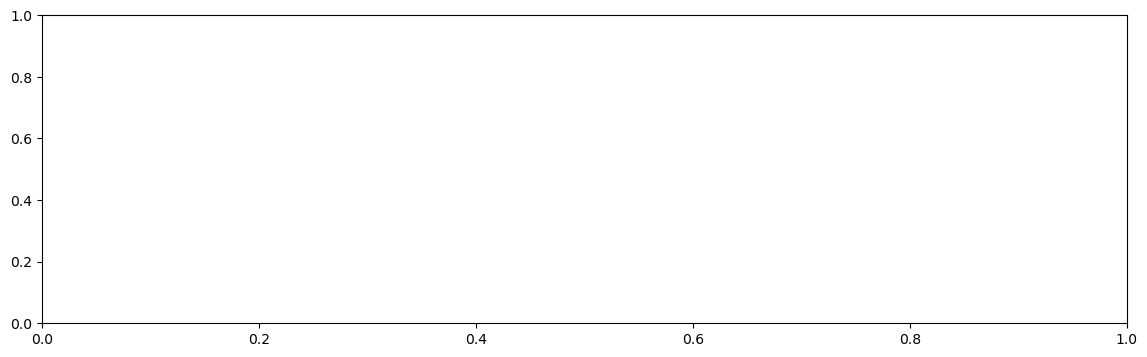

In [5]:
# plot the solution
directory = "permafrost_transect.demo"

def plot(directory, axs, style):
    # load the data
    vis = ats_xdmf.VisFile(directory, 'surface', time_unit='d')
    vis.loadMesh(columnar=True)
    dati = np.array([vis.getArray(v) for v in ["snow-depth","surface-elevation"]])

    x = vis.centroids[:,0,0]
    times = vis.times

    snow = colors.cm_mapper(-10, times[-1], colors.ice_cmap())

    axs.plot(x, dati[1,0,:], 'k')
    for (i,t) in enumerate(times):
        axs.plot(x, dati[1,0,:]+dati[0,i,:], color=snow(t), label='snow')


def decorate(axs):
    axs.set_xlabel('x coordinate [m]')
    axs.set_ylabel('z coordinate [m]')
    axs.legend()
    
fig, axs = plt.subplots(1,1, figsize=(14,4))
plot(directory, axs, '-')